#### Visualizing the original data (one hot-encoding)

In [ ]:
# from tensorflow.keras.models import load_model

In [1]:
import time

In [2]:
import tensorflow.compat.v1 as tf
from tensorflow.compat.v1.keras.models import load_model
tf.disable_v2_behavior()
import cv2

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.colors import ListedColormap

import tensorflow.compat.v1.keras.backend as K

In [4]:
# Defining a function to get a figure
def get_plot_data(dataset, nth_data, seq_length):
    
    # Get the data
    data_to_plot = dataset[nth_data:nth_data+1, :, :]
    data_to_plot = data_to_plot.reshape((data_to_plot.shape[0] * data_to_plot.shape[1]), data_to_plot.shape[2])
    data_to_plot = data_to_plot[:seq_length, :]
    data_to_plot = np.transpose(data_to_plot)
    
    # Plot the data
#     cmap = ListedColormap(['w', 'black'])
#     plt.matshow(data_to_plot, cmap = cmap, origin='lower')
#     ax = plt.gca()
#     plot = ax.xaxis.tick_bottom()
    
    #return data_to_plot, plot
    return data_to_plot

In [5]:
x_train = np.load('../r-scripts/getting-data-current/data-sets/x_train.npy')

In [13]:
x_train.shape[0]

462

In [6]:
get_plot_data(x_train, 30, 100)

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

#### Begin with the model

In [7]:
# Load the model
model = load_model("models/weights/cnn_lstm_30-0.41.hdf5")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [8]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 4034, 20)]   0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 4034, 32)     640         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 4032, 32)     1920        input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 4030, 32)     3200        input_1[0][0]                    
____________________________________________________________________________________________

In [9]:
data_test = x_train[20:20+1, :, :]

In [10]:
t = time.time()
pred = model.predict(data_test)
time.time() - t

6.965054035186768

In [14]:
def get_heatmap_matrix(dataset, nth_data, layer, verbose = False):
    
    #Get the data
    data = dataset[nth_data:nth_data+1, :, :]
    if verbose: print(data.shape)
    
    # Get the prediction from the model
    preds = model.predict(data)
    
    # Get the position that maximally activated 
    position = np.argmax(preds[0])
    if verbose: print(position)
    
    # Get the output of the layer and the data
    data_output = model.output[:, 0]
    
    # Get layer output
    get_layer = model.get_layer(layer)
    layer_output = get_layer.output
    
    # Calculate the gradients
    grads = K.gradients(data_output, layer_output)[0]
    if verbose: print(grads.shape)
    
    pooled_grads = K.mean(grads, axis = (0, 1))
    
    iterate = K.function([model.input], [pooled_grads, layer_output[0]])

    if verbose: print("Starting K iteration...")
    t = time.time()
    pooled_grads_value, layer_output_value = iterate([data])
    if verbose: print("Finished K iteration " + "(" + str(time.time() - t) + "seconds)")
    if verbose: print(layer_output_value.shape)

    if verbose: print("Starting loop...")
    t = time.time()
    # Looping
    for i in range(32):
        layer_output_value[:, i] *= pooled_grads_value[i]
        
    if verbose: print("Loop finished " + " (" + str(time.time() - t) + "seconds)" )
    # Get the heatmap matrix
    heatmap = np.mean(layer_output_value, axis = -1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    
    # Expand the dimensionality of heatmap so that it can be plot
    heatmap = np.expand_dims(heatmap, axis=0) 
    
    return heatmap

In [13]:
t = time.time()
res = get_heatmap_matrix(x_train, 20, "conv1d_1", False)
time.time() - t

(?, 4034, 32)


39.42143797874451

In [ ]:
res.shape

In [ ]:
plt.matshow(res[:, :30])

# Superposition

In [15]:
def create_superposition(dataset, seq_length, nth_data, nth_heat, heat_layer, heat_alpha = 0.4): 
    data = get_plot_data(dataset, nth_data, seq_length)
    heatmap = get_heatmap_matrix(dataset, nth_heat, heat_layer)[:,:seq_length]
    
    heatmap = cv2.resize(heatmap, (data.shape[1], data.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    data = np.uint8(255 - 255 * data)
    data = cv2.applyColorMap(data, cv2.COLORMAP_BONE)
    
    superimposed = heatmap * heat_alpha + data
    
    return (data, heatmap, superimposed)

In [17]:
(data, heatmap, superimposed) = create_superposition(
    dataset = x_train,
    seq_length = 100, 
    nth_data = 30, 
    nth_heat = 20, 
    heat_layer = "conv1d_1",
    heat_alpha = 0.4
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


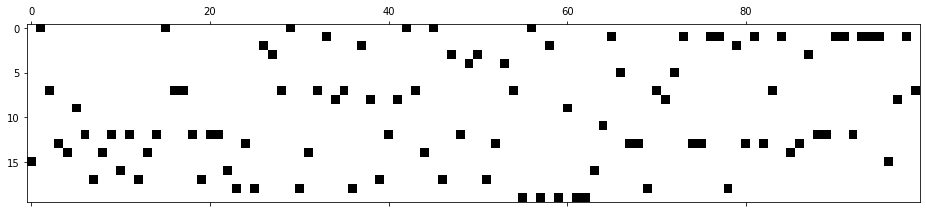

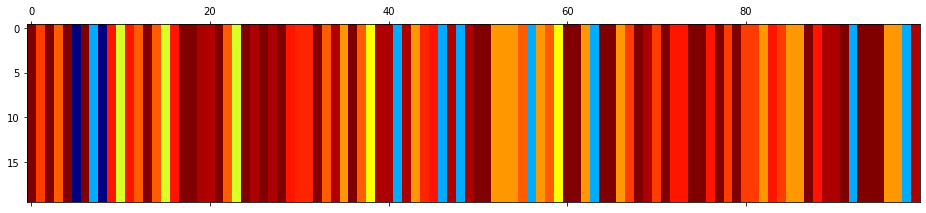

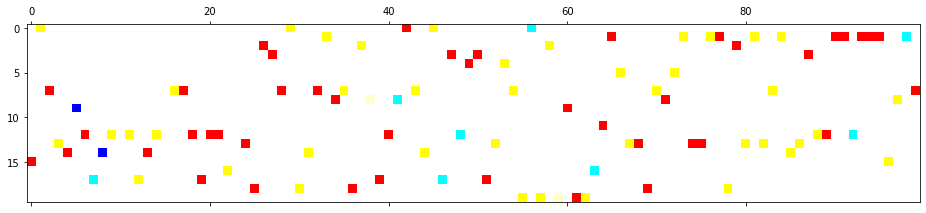

In [19]:
plt.matshow(data)
plt.matshow(heatmap)
plt.matshow(superimposed)